In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter


/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_49110/1898773768.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
V1_min, V1_max = 0, 1
V2_min, V2_max = 0, 1

dV1 = 0.05
dV2 = 0.05

[0. 1.]
[0.02092907 0.97907093]


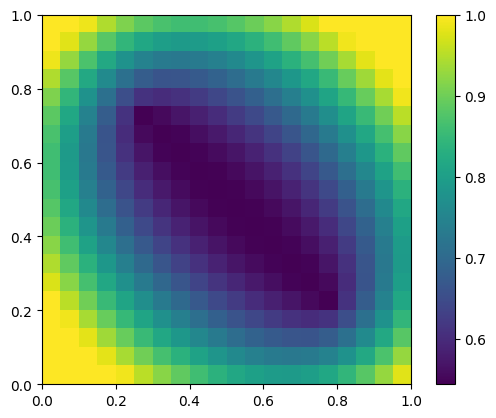

In [59]:
# Create a grid of voltage values from 0 to 1 with spacing 0.1
V1 = np.arange(V1_min, V1_max, dV1)
V2 = np.arange(V2_min, V2_max, dV2)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)/1.3
x0,y0 = 0.25,0.25
x1,y1 = 0.75,0.75

def create_prob_mesh(V1,V2):
    M, N = len(V1), len(V2)
    # Initialize an emp
    # ty array to store the probability vectors
    prob_mesh = np.empty((len(V1), len(V2), 2))
    
    for i in range(len(V1)):
        for j in range(len(V2)):
            # print(i,j)
            prob_mesh[i,j,:] = [1-min(1,distance(V1[i],V2[j],x0,y0)+distance(V1[i],V2[j],x1,y1)),min(1,distance(V1[i],V2[j],x0,y0)+distance(V1[i],V2[j],x1,y1)) ]

    # Apply the Gaussian filter to the distances.
    # prob_mesh = gaussian_filter(prob_mesh, sigma=10)

    return prob_mesh
prob_mesh = create_prob_mesh(V1,V2)
extent = [V1_min, V1_max, V2_min, V2_max]
print(prob_mesh[0,0,:])
print(prob_mesh[-1,-1,:])
plt.imshow(prob_mesh[:,:,1], extent=extent)
plt.colorbar()
plt.show()

In [55]:
def find_nearest_value(array, target_value):
    """
    Finds the value in an array that is closest to a target value.

    Args:
    array: NumPy array to search for the nearest value.
    target_value: Target value to find the nearest value to.

    Returns:
    The value in the array that is closest to the target value.
    """
    # Find the absolute differences between each value in the array and the target value.
    absolute_differences = np.abs(array - target_value)
    
    # Find the index of the minimum absolute difference.
    index_of_minimum_difference = np.argmin(absolute_differences)
    
    # Return the value at the index of the minimum absolute difference.
    return array[index_of_minimum_difference]


In [56]:
# V1_init, V2_init = 0.25,0.25
V1_init = (V1_max-V1_min)*(np.random.sample()) + V1_min
V2_init = (V2_max-V2_min)*(np.random.sample()) + V2_min
print("Starting: ", V1_init, V2_init)
print("Probability: ", prob_mesh[np.where(V1 == find_nearest_value(V1, V1_init))[0].item(), np.where(V2 == find_nearest_value(V2,V2_init))[0].item()])

Starting:  0.4400817116512268 0.6131404875391375
Probability:  [0.43190532 0.56809468]


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.04185814440648339
       x: [ 1.000e+00  1.000e+00]
    nfev: 15
   maxcv: 0.0


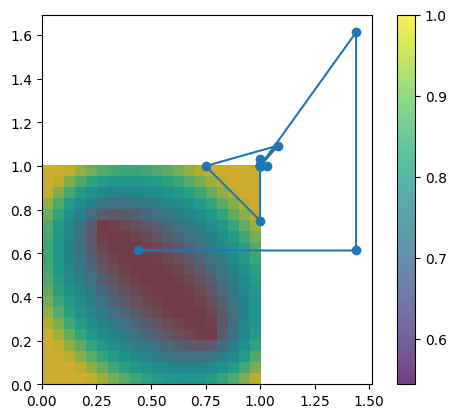

In [62]:

p_desired = [0,1]

points = []

def get_prob(voltages):

    v1,v2 = voltages[0], voltages[1]
    v1 = find_nearest_value(V1, v1)
    v2 = find_nearest_value(V2,v2)
    
    prob_vector = prob_mesh[np.where(V1 == v1)[0].item(), np.where(V2 == v2)[0].item()]
    return prob_vector

# Define the function that calculates the difference between the desired and actual probability vectors
def objective_function(voltages):
    # Calculate the actual probability vector given the current set of voltages
    # Calculate the difference between the actual and desired probability vectors
    points.append([voltages[0], voltages[1]])
    p_actual = get_prob(voltages)
    difference = np.sum(np.abs(p_desired - p_actual))
    return difference

bounds = [[V1_min, V1_max],[V2_min, V2_max]]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

plt.imshow(prob_mesh[:,:,0], extent=extent)
plt.imshow(prob_mesh[:,:,1], alpha=0.75,extent=extent)
plt.colorbar()
result = minimize(objective_function, x0=[V1_init, V2_init], constraints = cons, method='COBYLA')
print(result)
points = np.array(points)
plt.plot(points[:,0], points[:,1], '-o')
plt.show()
